## RNA-seq: Differential Expression of Transcription Factors


In addition to ATAC-STARR-seq, we also performed RNA-seq on the GM12878 and LCL8664 cell lines for two replicates each. Importantly, we simulated electroportation and cell response at 24 hours to foreign dsDNA as a means to capture transcript levels when ATAC-STARR-seq samples were harvested. With this data, we want to identify differentially expressed genes and pathways as a complement to the regulatory differeences we capture in ATAC-STARR. Furthermore, some genes may be more expressed because of intra-species genotype rather than inter-species selection. To add additional genotypees and get a high confidence set of diff expressed genes that represent species rather than individual, we also used human and macaque RNA-seq data for other individuals from Cain et al 2011. 

For this, I will merge our two technichal replicates into one biological. 

This comparative expression analysis between species is tricky though, because when done improperly many false positives can arise. For example othologs that are 2:1 or 3:1 would need 3 times as much RNA to seem to be at the same level in case vs. another. For that reason we only want to consider genes with 1:1 orthologs. While this seems easy enough at face, it is remarkably complex. To help myself, I'll be using an exon file generated by XSAnno. 

The first thing is to download the hg19-rheMac2 file from XSAnno for each genome and liftOver to hg38/rheMac10. There is no rheMac2 to rheMac10, so go to 8 then 10. 

Note: I did this code awhile ago and am placing it here for documentation sake. I am not re-running it

In [ ]:
%%bash
#download xsanno files.  

cd /data/hodges_lab/ATAC-STARR_V2/data/RNA-seq
#Hg
wget 'https://hbatlas.org/xsanno/files/Ensembl-v64-Human-Macaque/Ensembl.v64.fullTransExon.hg19TorheMac2.hg19.bed.gz'
gunzip Ensembl.v64.fullTransExon.hg19TorheMac2.hg19.bed.gz
liftOver Ensembl.v64.fullTransExon.hg19TorheMac2.hg19.bed \
  /data/hodges_lab/bin/map.chain/hg19ToHg38.over.chain.gz \
  Ensembl.v64.fullTransExon.hg19TorheMac2.hg38.bed Ensembl.v64.fullTransExon.hg19TorheMac2.unmapped.bed

#rheMac
wget 'https://hbatlas.org/xsanno/files/Ensembl-v64-Human-Macaque/Ensembl.v64.fullTransExon.hg19TorheMac2.rheMac2.bed.gz'
gunzip Ensembl.v64.fullTransExon.hg19TorheMac2.rheMac2.bed.gz

liftOver Ensembl.v64.fullTransExon.hg19TorheMac2.rheMac2.bed \
  /data/hodges_lab/bin/map.chain/rheMac2ToRheMac8.over.chain.gz \
  Ensembl.v64.fullTransExon.hg19TorheMac2.rheMac8.bed Ensembl.v64.fullTransExon.hg19TorheMac2.unmapped.bed

liftOver Ensembl.v64.fullTransExon.hg19TorheMac2.rheMac8.bed \
  /data/hodges_lab/bin/map.chain/rheMac8ToRheMac10.over.chain.gz \
  Ensembl.v64.fullTransExon.hg19TorheMac2.rheMac10.bed Ensembl.v64.fullTransExon.hg19TorheMac2.unmapped2.bed

In [ ]:
%%bash
#Convert bed files to gtf format for use in featureCounts. This awk statement re-orders columns and shifts the coordinate index. 

cd /data/hodges_lab/ATAC-STARR_V2/data/RNA-seq
awk '{print $1"\t""XSAnno_ensembl""\t""exon""\t"($2+1)"\t"$3"\t"".""\t"$6"\t"".""\t"$4}' Ensembl.v64.fullTransExon.hg19TorheMac2.hg38.bed | awk 'BEGIN {FS="|";OFS="\t"}{print $1,$2,$8}' - | awk 'BEGIN {FS=";";OFS="\t"}{print $1,$2,$3}' - | awk 'BEGIN{FS="\t";OFS=""}{print $1,"\t",$2,"\t",$3,"\t",$4,"\t",$5,"\t",$6,"\t",$7,"\t",$8,"\t","gene_id ","\"",$9,"\";"," transcript_id ","\"",$11,"\"; exon_number "$13}' | awk 'BEGIN{FS="Exon";OFS=""}{print $1,$2}' > Ensembl.v64.fullTransExon.hg19TorheMac2.hg38.gtf
awk '{print $1"\t""XSAnno_ensembl""\t""exon""\t"($2+1)"\t"$3"\t"".""\t"$6"\t"".""\t"$4}' Ensembl.v64.fullTransExon.hg19TorheMac2.rheMac10.bed | awk 'BEGIN {FS="|";OFS="\t"}{print $1,$2,$8}' - | awk 'BEGIN {FS=";";OFS="\t"}{print $1,$2,$3}' - | awk 'BEGIN{FS="\t";OFS=""}{print $1,"\t",$2,"\t",$3,"\t",$4,"\t",$5,"\t",$6,"\t",$7,"\t",$8,"\t","gene_id ","\"",$9,"\";"," transcript_id ","\"",$11,"\"; exon_number "$13}' | awk 'BEGIN{FS="Exon";OFS=""}{print $1,$2}' > Ensembl.v64.fullTransExon.hg19TorheMac2.rheMac10.gtf

### Trimming 

*Note: we did this for the Cain dataset in the notebook called "PCA". 

In [ ]:
%%bash
#Next trim and QC RNA-seq fastqs with trim galore! 
#Submitted this part as a slurm job. Script: RNA-seq_trimming.slrm

DATA_DIR='/data/hodges_lab/ATAC-STARR_V2/data/RNA-seq'
#GM12878
module restore trim_and_map
trim_galore --fastqc --fastqc_args "--outdir ${DATA_DIR}/processing_results/fastQC" \
    --paired --dont_gzip --basename GM12878_Rep1_RNA-seq --output_dir ${DATA_DIR}/fastq/trimmed_reads \
    ${DATA_DIR}/fastq/raw_reads/6231-TH-1_S1_L005_R1_001.fastq.gz \
    ${DATA_DIR}/fastq/raw_reads/6231-TH-1_S1_L005_R2_001.fastq.gz
trim_galore --fastqc --fastqc_args "--outdir ${DATA_DIR}/processing_results/fastQC" \
    --paired --dont_gzip --basename GM12878_Rep2_RNA-seq --output_dir ${DATA_DIR}/fastq/trimmed_reads \
    ${DATA_DIR}/fastq/raw_reads/6231-TH-2_S1_L005_R1_001.fastq.gz \
    ${DATA_DIR}/fastq/raw_reads/6231-TH-2_S1_L005_R2_001.fastq.gz
#LCL8664
trim_galore --fastqc --fastqc_args "--outdir ${DATA_DIR}/processing_results/fastQC" \
    --paired --dont_gzip --basename LCL8664_Rep1_RNA-seq --output_dir ${DATA_DIR}/fastq/trimmed_reads \
    ${DATA_DIR}/fastq/raw_reads/6231-TH-3_S1_L005_R1_001.fastq.gz \
    ${DATA_DIR}/fastq/raw_reads/6231-TH-3_S1_L005_R2_001.fastq.gz
trim_galore --fastqc --fastqc_args "--outdir ${DATA_DIR}/processing_results/fastQC" \
    --paired --dont_gzip --basename LCL8664_Rep2_RNA-seq --output_dir ${DATA_DIR}/fastq/trimmed_reads \
    ${DATA_DIR}/fastq/raw_reads/6231-TH-4_S1_L005_R1_001.fastq.gz \
    ${DATA_DIR}/fastq/raw_reads/6231-TH-4_S1_L005_R2_001.fastq.gz

### Mapping with STAR
With trimming done, it is time to align the reads to the human and rhesus genomes. Because RNA reads can cross exon-exon junctions we will use the STAR aligner which does "splice-aware" aligning to avoid this. To use STAR, we must first build a STAR index. 

To build a STAR index we need ensembl gtfs and fasta files for each genome. The fasta files are available at the goldenpath on UCSC genome browser. I've already downloaded these files previously. Making a STAR index takes ~45m so this needs to be submitted as a job. The script was called, "RNA-seq_build-STAR-indexes.slrm".

*Note: we did this for the Cain dataset in the notebook called "PCA". 

In [ ]:
%%bash
 #download ensembl gtfs
wget 'http://ftp.ensembl.org/pub/release-104/gtf/homo_sapiens/Homo_sapiens.GRCh38.104.gtf.gz'
wget 'http://ftp.ensembl.org/pub/release-104/gtf/macaca_mulatta/Macaca_mulatta.Mmul_10.104.gtf.gz'

#Now ensembl doesn't have chr prefix, so add with awk. Also remove metadata header. 
awk 'BEGIN{OFS=""}{if (NR>5) print "chr",$0}' /data/hodges_lab/hg38_genome/Homo_sapiens.GRCh38.104.gtf > \
  /data/hodges_lab/hg38_genome/Homo_sapiens.GRCh38.104.modified.gtf
  
awk 'BEGIN{OFS=""}{if (NR>5) print "chr",$0}' /data/hodges_lab/rheMac10_genome/Macaca_mulatta.Mmul_10.104.gtf > \
  /data/hodges_lab/rheMac10_genome/Macaca_mulatta.Mmul_10.104.modified.gtf

In [ ]:
%%bash
#generate indexes
HG38_FA='/data/hodges_lab/hg38_genome/hg38.fa'
HG38_GTF='/data/hodges_lab/hg38_genome/Homo_sapiens.GRCh38.104.modified.gtf'
RHEMAC10_FA='/data/hodges_lab/rheMac10_genome/rheMac10.fa'
RHEMAC10=GTF='/data/hodges_lab/rheMac10_genome/Macaca_mulatta.Mmul_10.104.modified.gtf'
module restore STAR

#hg38
STAR --runThreadN 8 \
--runMode genomeGenerate \
--genomeDir /data/hodges_lab/hg38_genome/hg38_GTF-ensembl.104_index_149 \
--genomeFastaFiles $HG38_FA \
--sjdbGTFfile $HG38_GTF \
--sjdbOverhang 149 #overhang is maximum readlength-1. Since we use the novaseq at 2x150, this is 149.

#rheMac10
STAR --runThreadN 8 \
--runMode genomeGenerate \
--genomeDir /data/hodges_lab/rheMac10_genome/rheMac10_GTF-ensembl.104_index_149 \
--genomeFastaFiles $RHEMAC10_FA \
--sjdbGTFfile $RHEMAC10_GTF \
--sjdbOverhang 149 #overhang is maximum readlength-1. Since we use the novaseq at 2x150, this is 149.

In [ ]:
%%bash
#Now we are ready to map! Submit this as a job using the script: RNA-seq_mapping.slrm

## Map to transcriptiome with STAR aligner. 
#Output mapped files as well as readcounts per gene by setting --quantmode GeneCounts.
module restore STAR
DATA_DIR='/data/hodges_lab/ATAC-STARR_V2/data/RNA-seq'
HG38_INDEX='/data/hodges_lab/hg38_genome/hg38_GTF-ensembl.104_index_149'
RHEMAC10_INDEX='/data/hodges_lab/rheMac10_genome/rheMac10_GTF-ensembl.104_index_149'
#GM12878
for EXPT in GM12878_Rep1_RNA-seq GM12878_Rep2_RNA-seq
do
    STAR --runMode alignReads --runThreadN 8 --genomeDir $HG38_INDEX --quantMode GeneCounts \
    --readFilesIn ${DATA_DIR}/fastq/trimmed_reads/${EXPT}_val_1.fq ${DATA_DIR}/fastq/trimmed_reads/${EXPT}_val_2.fq \
    --outFileNamePrefix ${DATA_DIR}/STAR-output/${EXPT}_ensembl.104_ --outSAMtype BAM SortedByCoordinate 
done

#LCL8664
for EXPT in LCL8664_Rep1_RNA-seq LCL8664_Rep2_RNA-seq
do
    STAR --runMode alignReads --runThreadN 8 --genomeDir $RHEMAC10_INDEX --quantMode GeneCounts \
    --readFilesIn ${DATA_DIR}/fastq/trimmed_reads/${EXPT}_val_1.fq ${DATA_DIR}/fastq/trimmed_reads/${EXPT}_val_2.fq \
    --outFileNamePrefix ${DATA_DIR}/STAR-output/${EXPT}_ensembl.104_ --outSAMtype BAM SortedByCoordinate 
done

### Make Counts Matricies for Differential Analysis
With reads mapped, next make a counts matrix with featureCounts for the XSAnno 1:1 ortholog exon set. This had to be submitted as a script: RNA-seq_featureCounts.slrm.  

*Note: we did this for the Cain dataset in the notebook called "PCA". 

In [ ]:
%%bash

HG38_FA='/data/hodges_lab/hg38_genome/hg38.fa'
HG38_GTF='/data/hodges_lab/ATAC-STARR_V2/data/RNA-seq/Ensembl.v64.fullTransExon.hg19TorheMac2.hg38.gtf'
RHEMAC10_FA='/data/hodges_lab/rheMac10_genome/rheMac10.fa'
RHEMAC10_GTF='/data/hodges_lab/ATAC-STARR_V2/data/RNA-seq/Ensembl.v64.fullTransExon.hg19TorheMac2.rheMac10.gtf'
DATA_DIR='/data/hodges_lab/ATAC-STARR_V2/data/RNA-seq'

#GM12878
featureCounts -s 1 -p -B -O -T 8 -F GTF -G $HG38_FA -t exon -g gene_id \
        -a $HG38_GTF -o ${DATA_DIR}/count_matricies/GM12878_RNA-seq_counts_XSAnno.tsv \
        ${DATA_DIR}/STAR-output/GM12878_Rep1_RNA-seq_ensembl.104_Aligned.sortedByCoord.out.bam \
        ${DATA_DIR}/STAR-output/GM12878_Rep2_RNA-seq_ensembl.104_Aligned.sortedByCoord.out.bam
#LCL8664
featureCounts -s 1 -p -B -O -T 8 -F GTF -G $RHEMAC10_FA -t exon -g gene_id \
        -a $RHEMAC10_GTF -o ${DATA_DIR}/count_matricies/LCL8664_RNA-seq_counts_XSAnno.tsv \
        ${DATA_DIR}/STAR-output/LCL8664_Rep1_RNA-seq_ensembl.104_Aligned.sortedByCoord.out.bam \
        ${DATA_DIR}/STAR-output/LCL8664_Rep2_RNA-seq_ensembl.104_Aligned.sortedByCoord.out.bam

### Differential Analysis with DESeq2 : read in counts
Move counts matrices over to local for analyzing with DESeq2. We will use DESeq2 to perform differential analysis on the conserved exons. After collecting results, threshold by FDR < 0.01 to identify differentially expressed gene sets and generate MA, dispEstimates, and volcano plots. Also plot a piechart of the genes. 

I read in the data using nearly the same code for the PCA, but then I select only the LCLs. 

In [5]:
suppressPackageStartupMessages(library(tidyverse))
suppressPackageStartupMessages(library(DESeq2))
suppressPackageStartupMessages(library(BiocParallel))
suppressPackageStartupMessages(library(apeglm))
register(MulticoreParam(2))

In [6]:
# r kernel
dir <- "/data/hodges_lab/ATAC-STARR_B-cells/data/RNA-seq/count_matricies/"

#read in cts
H_PE <- read_tsv(paste0(dir,"Human_cross-tissue_RNA-seq_counts_XSAnno_PE.tsv"), 
                     col_names = c("gene_id", "Chr", "Start", "End", "Strand", "Length", "GM12878_R1", "GM12878_R2"), 
                     skip = 2) %>% dplyr::select(-Chr, -Start, -End, -Strand, -Length)
                     
H_SE <- read_tsv(paste0(dir,"Human_cross-tissue_RNA-seq_counts_XSAnno_SE.tsv"), 
                     col_names = c("gene_id", "Chr", "Start", "End", "Strand", "Length", 
                     "Human_LCL_R1", "Human_LCL_R2", "Human_LCL_R3",
                     "Human_Heart_R1", "Human_Heart_R2", "Human_Heart_R3", "Human_Heart_R4",
                     "Human_Kidney_R1", "Human_Kidney_R2", "Human_Kidney_R3", "Human_Kidney_R4",
                     "Human_Liver_R1", "Human_Liver_R2", "Human_Liver_R3", "Human_Liver_R4",
                     "Human_Lung_R1", "Human_Lung_R2", "Human_Lung_R3", "Human_Lung_R4"), 
                     skip = 2) %>% dplyr::select(-Chr, -Start, -End, -Strand, -Length)

M_PE <- read_tsv(paste0(dir,"Macaque_cross-tissue_RNA-seq_counts_XSAnno_PE.tsv"), 
                     col_names = c("gene_id", "Chr", "Start", "End", "Strand", "Length", "LCL8664_R1", "LCL8664_R2"), 
                     skip = 2) %>% dplyr::select(-Chr, -Start, -End, -Strand, -Length)
                     
M_SE <- read_tsv(paste0(dir,"Macaque_cross-tissue_RNA-seq_counts_XSAnno_SE.tsv"), 
                     col_names = c("gene_id", "Chr", "Start", "End", "Strand", "Length", 
                     "Macaque_LCL_R1", "Macaque_LCL_R2", "Macaque_LCL_R3",
                     "Macaque_Heart_R1", "Macaque_Heart_R2", "Macaque_Heart_R3", "Macaque_Heart_R4",
                     "Macaque_Kidney_R1", "Macaque_Kidney_R2", "Macaque_Kidney_R3", "Macaque_Kidney_R4",
                     "Macaque_Liver_R1", "Macaque_Liver_R2", "Macaque_Liver_R3", "Macaque_Liver_R4",
                     "Macaque_Lung_R1", "Macaque_Lung_R2", "Macaque_Lung_R3", "Macaque_Lung_R4"), 
                     skip = 2) %>% dplyr::select(-Chr, -Start, -End, -Strand, -Length)

Rows: 27898 Columns: 8

── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr (5): gene_id, Chr, Start, End, Strand
dbl (3): Length, GM12878_R1, GM12878_R2


ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.

Rows: 27898 Columns: 25

── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr  (5): gene_id, Chr, Start, End, Strand
dbl (20): Length, Human_LCL_R1, Human_LCL_R2, Human_LCL_R3, Human_Heart_R1, ...


ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.

Rows: 27762 Columns: 8

── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr (5): gene_id, Chr, Start, End, Strand
dbl (3): Length, LCL8664_R1, LCL8664_R2


ℹ Use `spec()` to retrieve the fu

In [7]:
#join counts and assign gene_id to row_names
cts_1 <- inner_join(H_PE, H_SE, by = "gene_id") %>%
    inner_join(M_PE, by = "gene_id") %>%
    inner_join(M_SE, by = "gene_id") %>% 
    dplyr::select(gene_id, GM12878_R1, GM12878_R2, Human_LCL_R1, Human_LCL_R2, Human_LCL_R3, 
                  LCL8664_R1, LCL8664_R2, Macaque_LCL_R1, Macaque_LCL_R2, Macaque_LCL_R3) 

cts_2 <- column_to_rownames(cts_1, var = "gene_id") %>% 
    as.matrix()

### Run DESeq2

In [8]:
# Prepare dataframe of sample info
RNames <- c("GM12878_R1", "GM12878_R2", "Human_LCL_R1", "Human_LCL_R2", "Human_LCL_R3", 
             "LCL8664_R1", "LCL8664_R2", "Macaque_LCL_R1", "Macaque_LCL_R2", "Macaque_LCL_R3")

species <- c("Human", "Human", "Human", "Human", "Human", 
             "Macaque", "Macaque", "Macaque", "Macaque", "Macaque")

bio_rep <- c("Human_Rep1", "Human_Rep1", "Human_Rep2", "Human_Rep3", "Human_Rep4", 
             "Macaque_Rep1", "Macaque_Rep1", "Macaque_Rep2", "Macaque_Rep3", "Macaque_Rep4")

tech_rep <- c("Rep1", "Rep2", "Rep1", "Rep1", "Rep1", 
             "Rep1", "Rep2", "Rep1", "Rep1", "Rep1")

batch <- c("batch_1", "batch_1", "batch_2", "batch_2", "batch_2", 
             "batch_1", "batch_1", "batch_2", "batch_2", "batch_2")

coldata <- data.frame(row.names = RNames, species, bio_rep, tech_rep, batch)

In [9]:
#check that the coldata matches data. It should print TRUE. 
print(all(rownames(coldata) == colnames(cts_2))) 

[1] TRUE


In [10]:
#normalize counts with DESeq2:
dds <- DESeqDataSetFromMatrix(countData = cts_2,
                              colData = coldata,
                              design = ~ batch + species)

converting counts to integer mode

Warning message in DESeqDataSet(se, design = design, ignoreRank):
“some variables in design formula are characters, converting to factors”


In [11]:
dds_bio <- collapseReplicates(dds, dds$bio_rep, dds$tech_rep, renameCols = TRUE)

colData(dds_bio)
colnames(dds_bio)

DataFrame with 8 rows and 5 columns
              species      bio_rep    tech_rep    batch runsCollapsed
             <factor>  <character> <character> <factor>   <character>
Human_Rep1    Human     Human_Rep1        Rep1  batch_1     Rep1,Rep2
Human_Rep2    Human     Human_Rep2        Rep1  batch_2          Rep1
Human_Rep3    Human     Human_Rep3        Rep1  batch_2          Rep1
Human_Rep4    Human     Human_Rep4        Rep1  batch_2          Rep1
Macaque_Rep1  Macaque Macaque_Rep1        Rep1  batch_1     Rep1,Rep2
Macaque_Rep2  Macaque Macaque_Rep2        Rep1  batch_2          Rep1
Macaque_Rep3  Macaque Macaque_Rep3        Rep1  batch_2          Rep1
Macaque_Rep4  Macaque Macaque_Rep4        Rep1  batch_2          Rep1

[1] "Human_Rep1"   "Human_Rep2"   "Human_Rep3"   "Human_Rep4"   "Macaque_Rep1"
[6] "Macaque_Rep2" "Macaque_Rep3" "Macaque_Rep4"

In [12]:
#differential expression analysis.
dds <- DESeq(dds, parallel=TRUE, BPPARAM=MulticoreParam(2))

estimating size factors

estimating dispersions

gene-wise dispersion estimates: 2 workers

mean-dispersion relationship

final dispersion estimates, fitting model and testing: 2 workers



### Output normalized read count

We will also need DESeq2 normalized read counts so make a new df and export those here.

In [10]:
suppressPackageStartupMessages(library(org.Hs.eg.db))
counts <- counts(dds, normalized = TRUE) %>% as.data.frame() %>% rownames_to_column(var = "gene_id")
counts_gene <- clusterProfiler::bitr(counts$gene_id, fromType = "ENSEMBL", toType = "SYMBOL", OrgDb = org.Hs.eg.db, drop = FALSE)

counts <- left_join(cts_1, counts_gene, by = c("gene_id" = "ENSEMBL")) %>% relocate(SYMBOL, .before = GM12878_R1)

head(counts)

write_tsv(counts, "/data/hodges_lab/ATAC-STARR_B-cells/data/RNA-seq/human_LCLs-vs-rhesus_LCLs_DESeq2-normalized_counts.tsv", col_names = TRUE)



'select()' returned 1:many mapping between keys and columns

Warning message in clusterProfiler::bitr(counts$gene_id, fromType = "ENSEMBL", toType = "SYMBOL", :
“25.84% of input gene IDs are fail to map...”


gene_id,SYMBOL,GM12878_R1,GM12878_R2,Human_LCL_R1,Human_LCL_R2,Human_LCL_R3,LCL8664_R1,LCL8664_R2,Macaque_LCL_R1,Macaque_LCL_R2,Macaque_LCL_R3
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
ENSG00000101557,USP14,2403,1975,311,431,226,2309,1739,543,546,612
ENSG00000079134,THOC1,3643,3308,142,145,79,4637,3347,198,153,192
ENSG00000158270,COLEC12,3,2,8,19,0,1,1,1,0,0
ENSG00000079101,CLUL1,55,48,11,2,5,5,3,0,0,0
ENSG00000176912,TYMSOS,573,521,287,375,244,1307,1006,242,242,296
ENSG00000176890,TYMS,6239,6385,2845,3742,2054,6984,5859,1616,1794,2007


### Extract results

In [13]:
#Extract results comparing GM to LCL (L2FC = GM/LCL). 
res <- results(dds, name = "species_Macaque_vs_Human")
res_df <-  as.data.frame(res) %>% rownames_to_column( var = "gene_id")

### Volcano Plot

In [16]:
#Plot Volcano plot. First make a new column that classifies each region based on the cutoffs and then order the factored values. 
res_volcano <- mutate(res_df, 
                      Classification = case_when(padj < 0.001 & log2FoldChange > 2 ~ "Rhesus-Specific", 
                                                             padj < 0.001 & log2FoldChange < -2 ~ "Human-Specific", 
                                                             padj >= 0.001 | (log2FoldChange < 2 & log2FoldChange > -2) ~ "Stable")) %>% filter(Classification != "NA")

res_volcano$Classification <- factor(res_volcano$Classification, levels = c("Rhesus-Specific", "Stable", "Human-Specific"))

#Plot L2fc and -log10(padj) against each other and color by classificaiton above. 
p <- ggplot(res_volcano) +
  geom_point(aes(x=-log2FoldChange, y=-log10(padj), colour=Classification), size=0.5) +
  geom_hline(yintercept = c(-log10(0.001)), linetype = "dashed") +
  geom_vline(xintercept = c(-2,2), linetype = "dashed") +
  xlab("log2 Fold-Change (Rhesus/Human)") +
  ylab("-log10 BH-adjusted p-value") +
  theme_bw(base_size = 10, base_family = "Arial") +
  theme(legend.position="bottom", legend.title = element_blank()) +
  scale_colour_manual(values=c("orange", "lightgrey", "dodgerblue")) + 
  guides(colour = guide_legend(override.aes = list(size = 2)))

Warning message:
“Removed 5049 rows containing missing values (geom_point).”


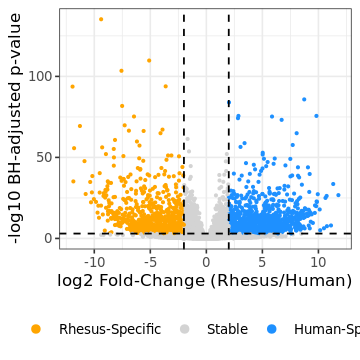

In [17]:
options(repr.plot.width = 3, repr.plot.height = 3)
p

In [18]:
ggsave(filename = "/data/hodges_lab/ATAC-STARR_B-cells/results/results_human-evolution/RNA-expression_human-LCLs-vs-rhesus-LCLs_volcano.pdf", 
      plot = p, device = cairo_pdf, height = 3, width = 3)

Warning message:
“Removed 5049 rows containing missing values (geom_point).”


In [71]:
# how many differentially expressed genes?
dplyr::count(res_volcano, Classification)

Classification,n
<chr>,<int>
Human-Specific,1288
Rhesus-Specific,986
Stable,19663


### QC plots

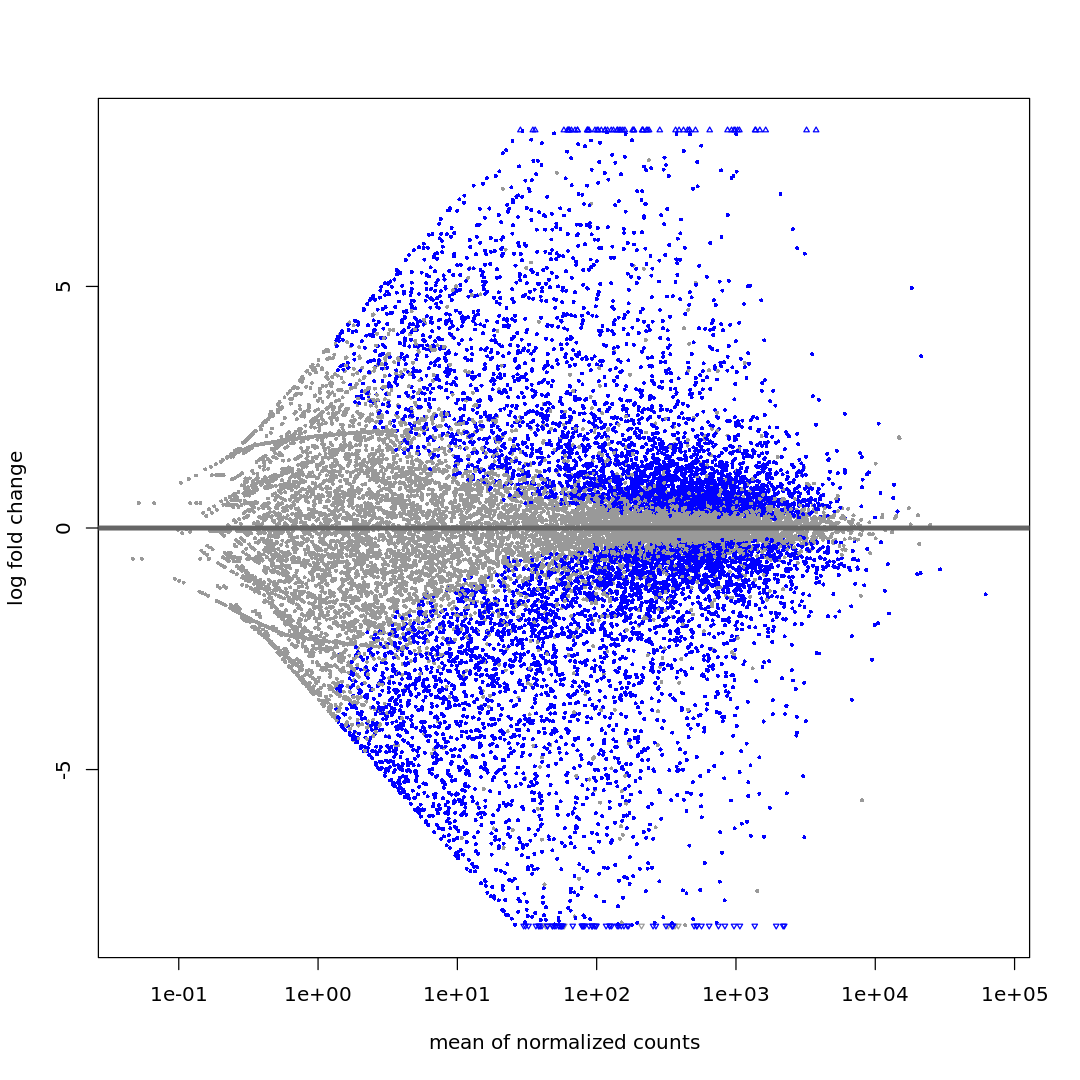

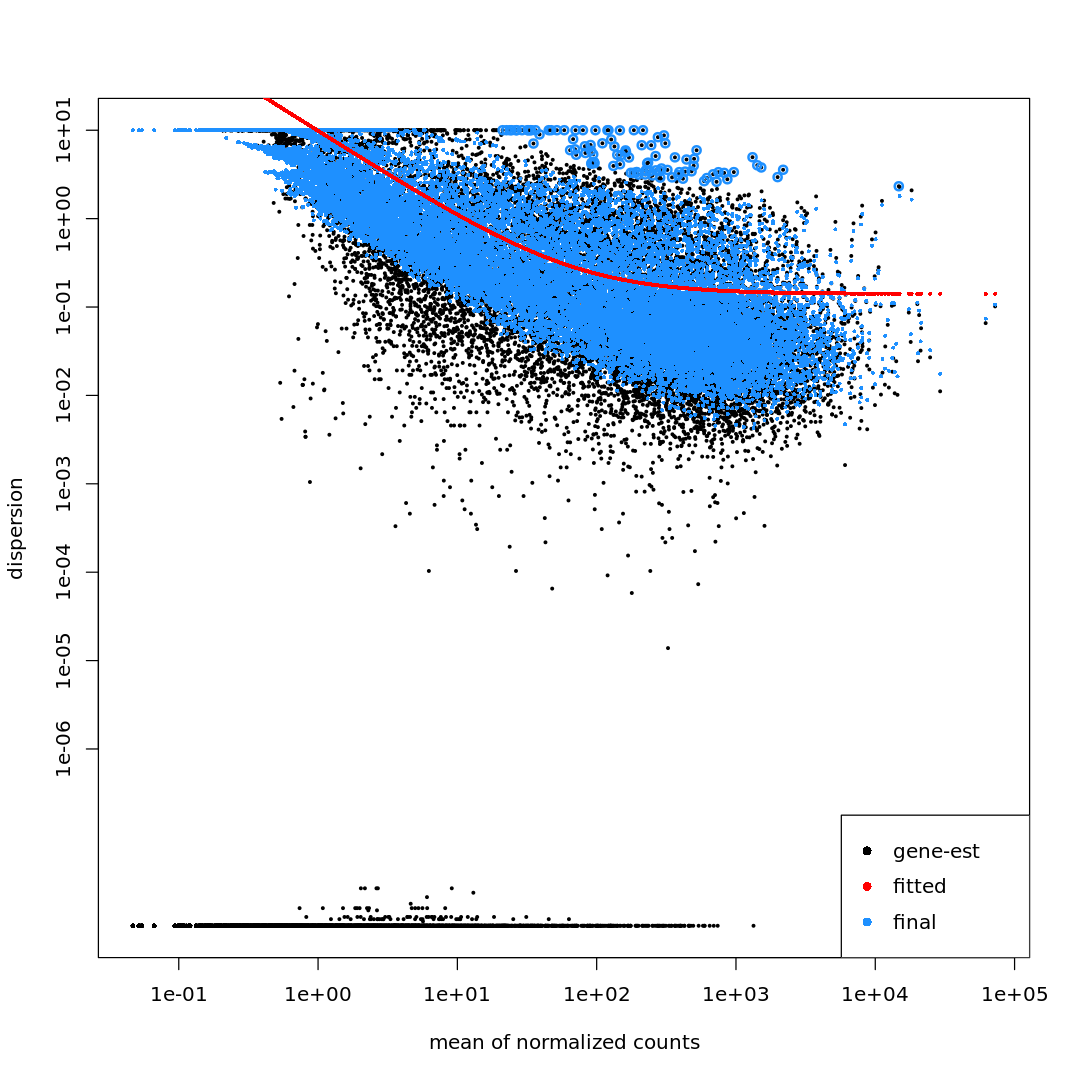

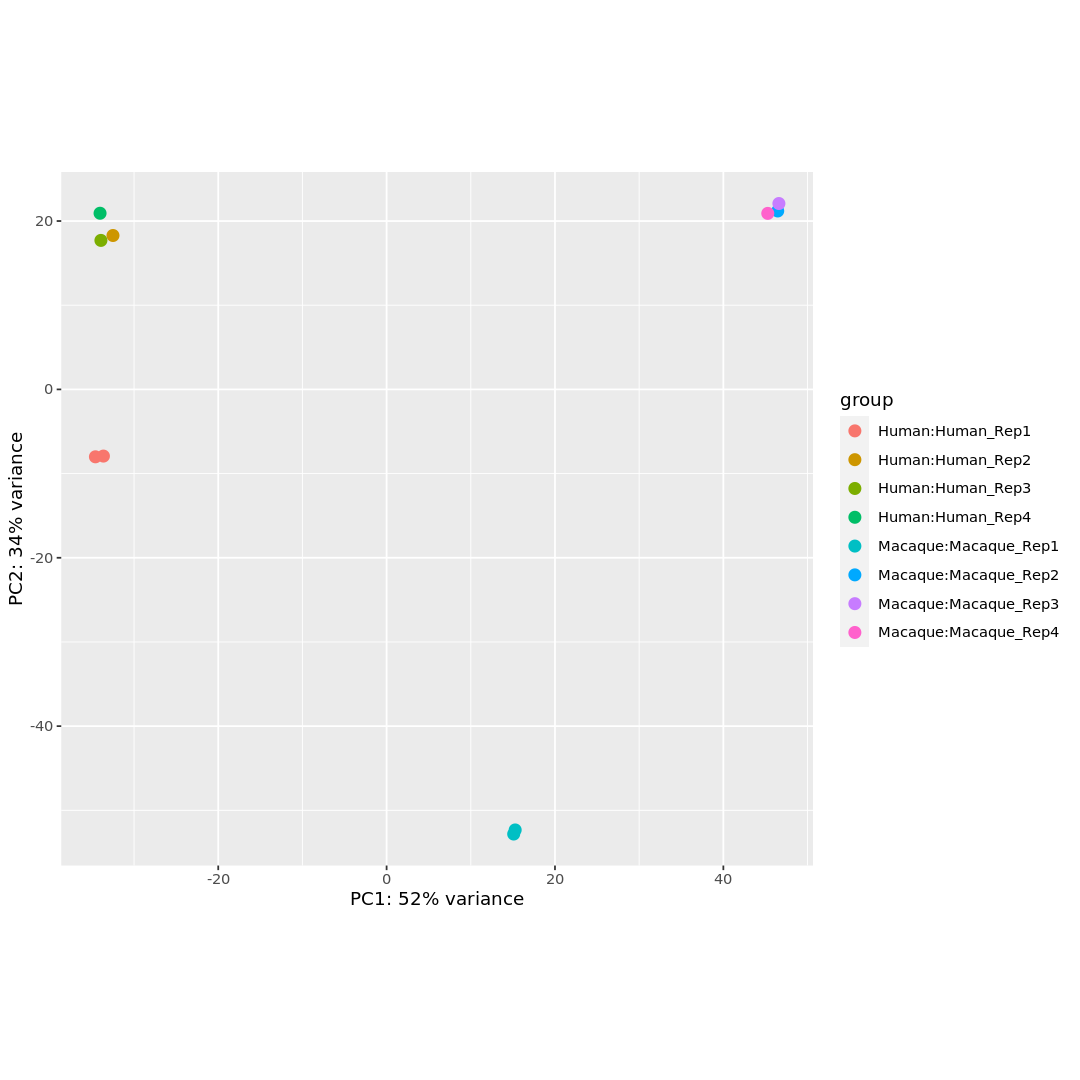

In [20]:
options(repr.plot.width = 9, repr.plot.height = 9)

#MA plot (log ratio vs average counts). This shows shrinkage applied by apeglm. 
plotMA(res)
#Dispersion estimates plot shows how DESeq transformed values by dispersion estimation. 
p <- plotDispEsts(dds)
#PCA plot to see how samples group to see batch effects. To do this, first VST transform the values and plot. Do this not blind because we want the estimated dispersion applied to the differential analysis. 
vsd <- vst(dds, blind=FALSE)
plotPCA(vsd, intgroup=c("species", "bio_rep"))

In [21]:
ggsave(plotPCA(vsd, intgroup=c("species", "bio_rep")), 
       filename = "/data/hodges_lab/ATAC-STARR_B-cells/results/results_human-evolution/QC_pca-plot_human-LCLs-vs-macaque-LCLs.pdf", 
       device = cairo_pdf, width = 6, height = 6)

### Write out differential expression values for each gene

In [14]:
#convert ENS ID to symbol for sorting
library(org.Hs.eg.db)
gene_ids <- clusterProfiler::bitr(res_df$gene_id, fromType = "ENSEMBL", toType = "SYMBOL", OrgDb = org.Hs.eg.db, drop = TRUE)

head(gene_ids)

res_df_symbol <- left_join(gene_ids, res_df, by = c("ENSEMBL" = "gene_id"))

head(res_df_symbol)

Loading required package: AnnotationDbi


Attaching package: ‘AnnotationDbi’


The following object is masked from ‘package:dplyr’:

    select






'select()' returned 1:many mapping between keys and columns

Warning message in clusterProfiler::bitr(res_df$gene_id, fromType = "ENSEMBL", toType = "SYMBOL", :
“25.84% of input gene IDs are fail to map...”


,ENSEMBL,SYMBOL
,<chr>,<chr>
1,ENSG00000101557,USP14
2,ENSG00000079134,THOC1
3,ENSG00000158270,COLEC12
4,ENSG00000079101,CLUL1
5,ENSG00000176912,TYMSOS
6,ENSG00000176890,TYMS


,ENSEMBL,SYMBOL,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,ENSG00000101557,USP14,829.066408,0.3826395,0.1737942,2.2016811,2.768784e-02,6.119516e-02
2,ENSG00000079134,THOC1,941.223864,0.3639006,0.1791494,2.0312683,4.222778e-02,8.732005e-02
3,ENSG00000158270,COLEC12,4.535965,-3.2593107,1.3793444,-2.3629420,1.813051e-02,4.280554e-02
4,ENSG00000079101,CLUL1,8.547163,-4.1458533,0.8791486,-4.7157597,2.408105e-06,1.523149e-05
5,ENSG00000176912,TYMSOS,433.197058,0.2388227,0.3318818,0.7196016,4.717703e-01,5.899205e-01
6,ENSG00000176890,TYMS,3442.515357,-0.4535940,0.2553059,-1.7766683,7.562283e-02,1.403273e-01


In [23]:
write_tsv(res_df_symbol, file = paste0(dir, 'diff_expression_res_gene-symbols_human-LCLs-vs-macaque-LCLs.tsv'), col_names = TRUE)

### Focus on TFs only

In [15]:
#join to tsv that has symbols for TFs only. 
tfs <- read_tsv("~/TF_names_v_1.01.txt", col_names = c("gene_symbol"))

Rows: 1639 Columns: 1

── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr (1): gene_symbol


ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.



In [16]:
TFs_res <- inner_join(tfs, res_df_symbol, by = c("gene_symbol" = "SYMBOL"))

head(TFs_res)
nrow(TFs_res)

gene_symbol,ENSEMBL,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
ADNP,ENSG00000101126,2598.010099,-0.05219083,0.1814327,-0.2876594,0.77360747,0.8420136
ADNP2,ENSG00000101544,37.058647,0.73086092,0.3850767,1.8979620,0.05770109,0.1129673
AEBP1,ENSG00000106624,23.787859,-2.84511595,1.1508559,-2.4721740,0.01342941,0.0331234
AEBP2,ENSG00000139154,877.667513,-0.02582530,0.1057036,-0.2443180,0.80698454,0.8669644
AHCTF1,ENSG00000153207,3.798549,-0.58560311,0.8704176,-0.6727841,0.50108465,0.6156652
AHDC1,ENSG00000126705,529.719508,0.09029767,0.3680747,0.2453243,0.80620531,0.8664924


[1] 1385

In [26]:
write_tsv(TFs_res, file = paste0(dir, 'TFs-only_diff_expression_res_gene-symbols_human-LCLs-vs-macaque-LCLs.tsv'), col_names = TRUE)

#### Volcano Text TF Differential Expression

Warning message:
“ggrepel: 33 unlabeled data points (too many overlaps). Consider increasing max.overlaps”


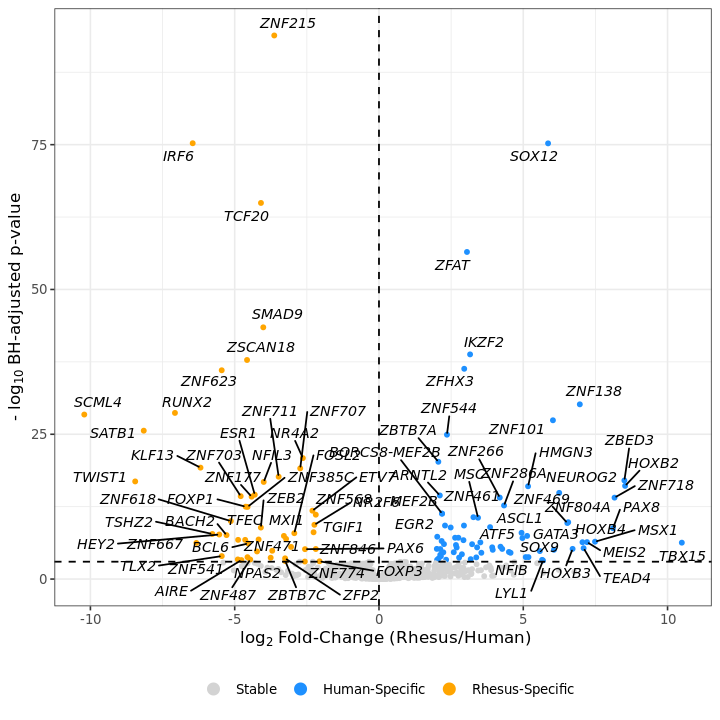

In [27]:
#Plot Volcano plot. First make a new column that classifies each region based on the cutoffs and then order the factored values. 
res_volcano_TF <- mutate(TFs_res, 
                      Classification = case_when(padj < 0.001 & log2FoldChange > 2 ~ "Rhesus-Specific", 
                                                             padj < 0.001 & log2FoldChange < -2 ~ "Human-Specific", 
                                                             padj >= 0.001 | (log2FoldChange == 0) ~ "Stable")) %>% filter(Classification != "NA")

res_volcano_TF$Classification <- factor(res_volcano_TF$Classification, levels = c("Stable","Human-Specific","Rhesus-Specific"))

res_volcano_text <- filter(res_volcano_TF, Classification %in% c("Human-Specific", "Rhesus-Specific"))

#Plot L2fc and -log10(padj) against each other and color by classificaiton above. 
p <- ggplot(res_volcano_TF, aes(x=-log2FoldChange, y=-log10(padj), colour=Classification)) +
  geom_point(size=1) +
  ggrepel::geom_text_repel(data = res_volcano_text, aes(x=-log2FoldChange, y=-log10(padj), label=gene_symbol), 
                           fontface = "italic", colour = "black", size = 3, max.overlaps = 30) +
  geom_hline(yintercept = c(-log10(0.001)), linetype = "dashed") +
  geom_vline(xintercept = c(0), linetype = "dashed") +
  xlab(bquote(~log[2]~"Fold-Change (Rhesus/Human)")) +
  ylab(bquote("-"~log[10]~"BH-adjusted p-value")) +
  theme_bw(base_size = 10, base_family = "Arial") +
  theme(legend.position="bottom", legend.title = element_blank()) +
  scale_colour_manual(values=c("lightgrey", "dodgerblue", "orange")) + 
  guides(colour = guide_legend(override.aes = list(size = 3)))

options(repr.plot.width = 6, repr.plot.height = 6)
p

In [28]:
ggsave(p, filename = "/data/hodges_lab/ATAC-STARR_B-cells/results/results_human-evolution/gene_expression_evolution_human-LCLs-vs-macaque-LCLs.pdf", 
       device = cairo_pdf, width = 6, height = 6)

Warning message:
“ggrepel: 44 unlabeled data points (too many overlaps). Consider increasing max.overlaps”


### Pathway enrichment of the differentially expressed genes

In [29]:
library(ReactomePA)
library(magrittr)

ReactomePA v1.38.0  For help: https://yulab-smu.top/biomedical-knowledge-mining-book/

If you use ReactomePA in published research, please cite:
Guangchuang Yu, Qing-Yu He. ReactomePA: an R/Bioconductor package for reactome pathway analysis and visualization. Molecular BioSystems 2016, 12(2):477-479


Attaching package: ‘magrittr’


The following object is masked from ‘package:purrr’:

    set_names


The following object is masked from ‘package:tidyr’:

    extract




In [30]:
#split results
res_volcano$Classification %<>% as.character()
human <- dplyr::filter(res_volcano, Classification == "Human-Specific")
macaque <- dplyr::filter(res_volcano, Classification == "Rhesus-Specific")

In [31]:
# get entrez
human_gene <- clusterProfiler::bitr(geneID = human$gene_id, OrgDb = org.Hs.eg.db, fromType = "ENSEMBL", toType = "ENTREZID")
macaque_gene <- clusterProfiler::bitr(geneID = macaque$gene_id, OrgDb = org.Hs.eg.db, fromType = "ENSEMBL", toType = "ENTREZID")

'select()' returned 1:many mapping between keys and columns

Warning message in clusterProfiler::bitr(geneID = human$gene_id, OrgDb = org.Hs.eg.db, :
“13.74% of input gene IDs are fail to map...”
'select()' returned 1:many mapping between keys and columns

Warning message in clusterProfiler::bitr(geneID = macaque$gene_id, OrgDb = org.Hs.eg.db, :
“11.05% of input gene IDs are fail to map...”


In [32]:
#pathway enrichment
res_hu <- enrichPathway(gene = human_gene$ENTREZID, pvalueCutoff = 0.2, pAdjustMethod = "none")
res_ma <- enrichPathway(gene = macaque_gene$ENTREZID, pvalueCutoff = 0.2, pAdjustMethod = "none")

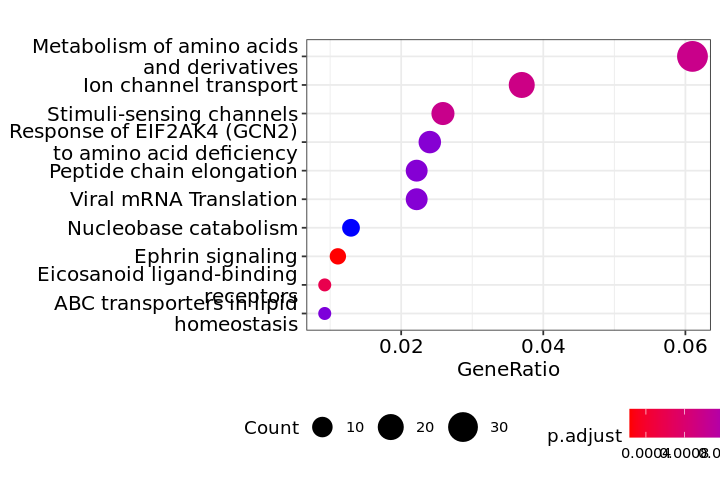

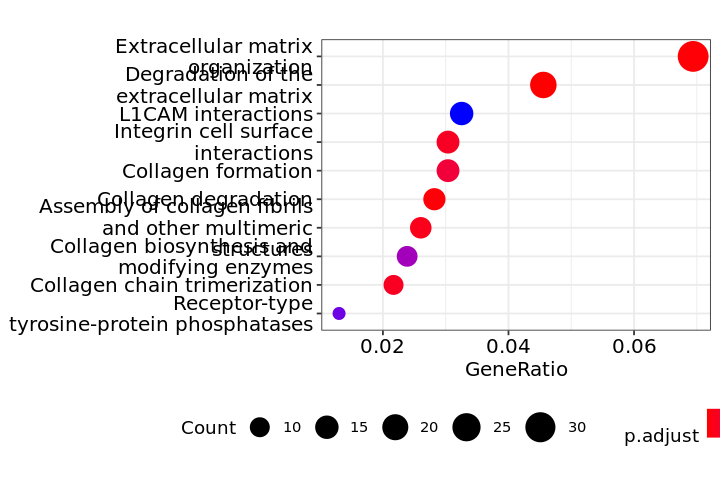

In [33]:
options(repr.plot.width = 6, repr.plot.height = 4)
dotplot(res_hu, showCategory = 10) + theme(legend.position = "bottom") 
dotplot(res_ma, showCategory = 10) + theme(legend.position = "bottom")

In [34]:
ggsave(dotplot(res_hu, showCategory = 6) + theme(legend.position = "bottom"), filename = "/data/hodges_lab/ATAC-STARR_B-cells/results/results_human-evolution/reactome_human_human-LCLs-vs-macaque-LCLs.pdf", 
       device = cairo_pdf, width = 6, height = 4)

In [35]:
ggsave(dotplot(res_ma, showCategory = 6) + theme(legend.position = "bottom"), filename = "/data/hodges_lab/ATAC-STARR_B-cells/results/results_human-evolution/reactome_mac_human-LCLs-vs-macaque-LCLs.pdf", 
       device = cairo_pdf, width = 6, height = 4)

In [36]:
library(clusterProfiler)

clusterProfiler v4.2.0  For help: https://yulab-smu.top/biomedical-knowledge-mining-book/

If you use clusterProfiler in published research, please cite:
T Wu, E Hu, S Xu, M Chen, P Guo, Z Dai, T Feng, L Zhou, W Tang, L Zhan, X Fu, S Liu, X Bo, and G Yu. clusterProfiler 4.0: A universal enrichment tool for interpreting omics data. The Innovation. 2021, 2(3):100141


Attaching package: ‘clusterProfiler’


The following object is masked from ‘package:AnnotationDbi’:

    select


The following object is masked from ‘package:IRanges’:

    slice


The following object is masked from ‘package:S4Vectors’:

    rename


The following object is masked from ‘package:purrr’:

    simplify


The following object is masked from ‘package:stats’:

    filter




In [37]:
gene_list <- list(human = human_gene$ENTREZID, macaque = macaque_gene$ENTREZID)
result <- compareCluster(gene_list, fun = "enrichPathway", pvalueCutoff = 0.2, pAdjustMethod = "none")

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.



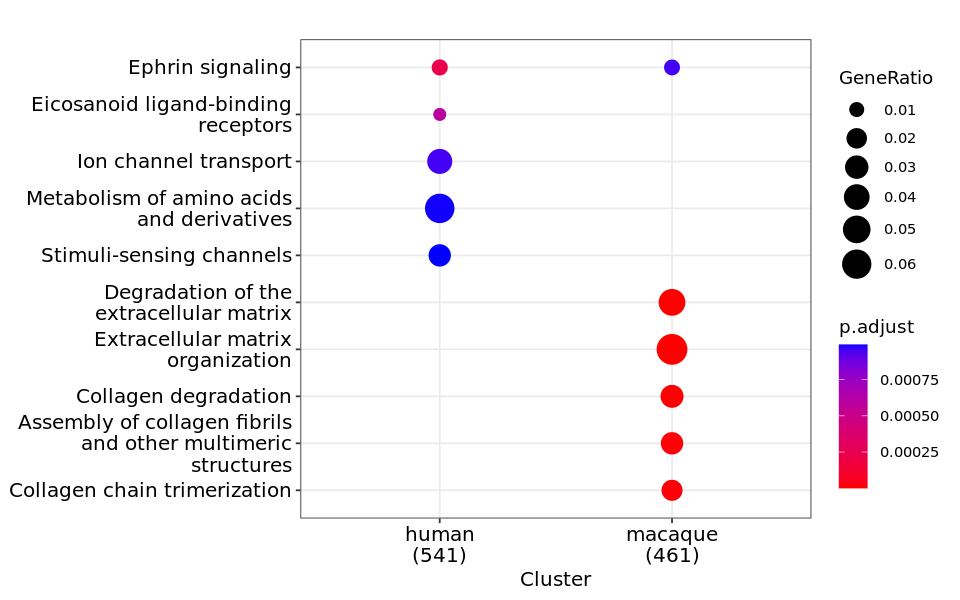

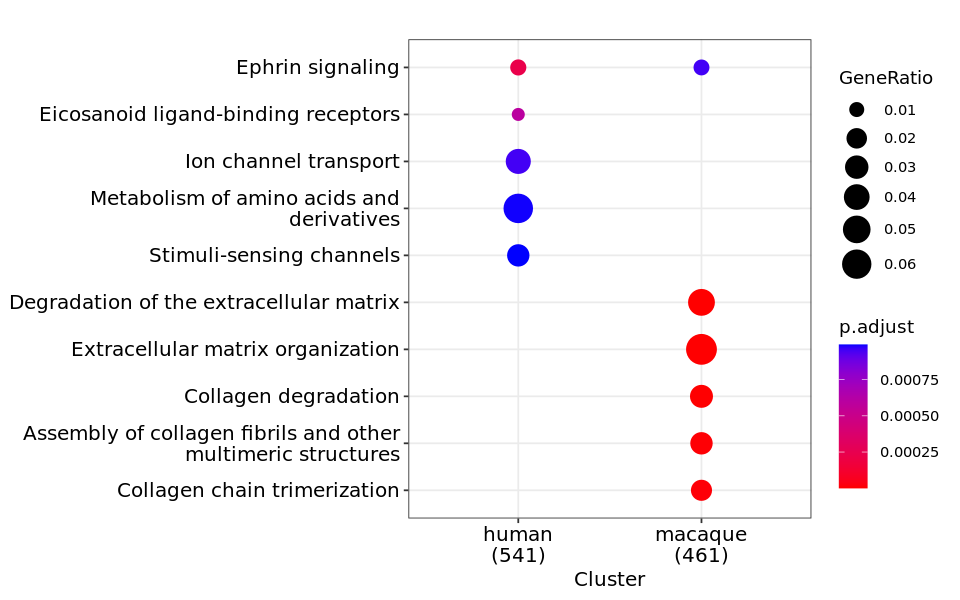

In [38]:
options(repr.plot.width = 8, repr.plot.height = 5)
dotplot(result, showCategory = 5) + scale_y_discrete(labels = function(x) str_wrap(x, width = 40))

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.



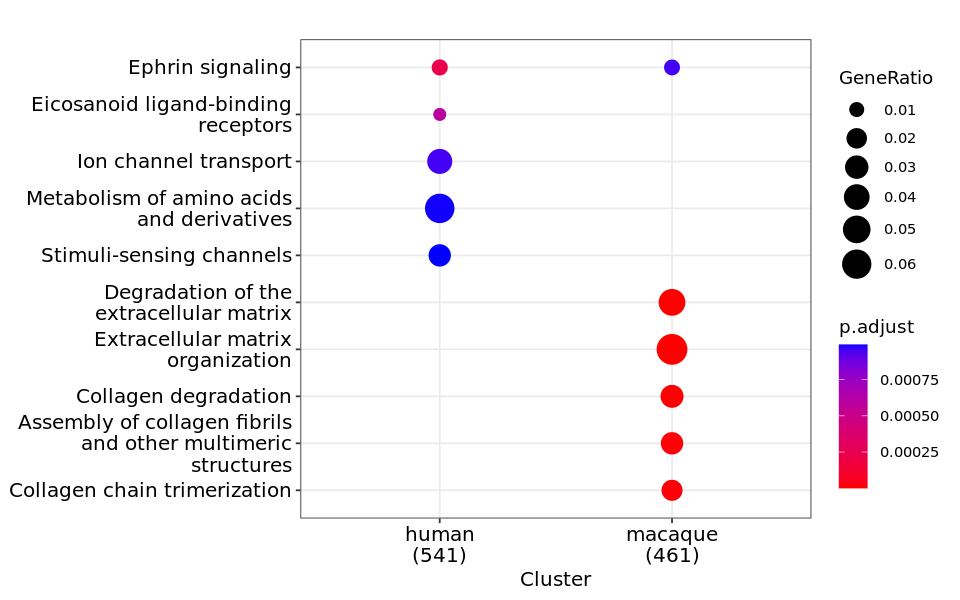

In [39]:
p <- dotplot(result, showCategory = 5) + scale_y_discrete(labels = function(x) str_wrap(x, width = 40))

In [40]:
ggsave(p, filename = "/data/hodges_lab/ATAC-STARR_B-cells/results/results_human-evolution/reactome_all_human-LCLs-vs-macaque-LCLs.pdf", 
       device = cairo_pdf, width = 8, height = 5)

## Plot ETS1 and RUNX3 TPM values

In [41]:
library(tidyverse)

norm_cts <- read_tsv("/data/hodges_lab/ATAC-STARR_B-cells/data/RNA-seq/human_LCLs-vs-rhesus_LCLs_DESeq2-normalized_counts.tsv") %>%
    filter(SYMBOL %in% c("ETS1", "RUNX3")) %>% select(-gene_id)

Rows: 27860 Columns: 12

── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr  (2): gene_id, SYMBOL
dbl (10): GM12878_R1, GM12878_R2, Human_LCL_R1, Human_LCL_R2, Human_LCL_R3, ...


ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.



In [42]:
norm_cts <- pivot_longer(norm_cts, !SYMBOL, names_to = "sample", values_to = "TPM") %>% 
    mutate(species = case_when(sample %in% c("GM12878_R1", "GM12878_R2", "Human_LCL_R1", "Human_LCL_R2", "Human_LCL_R3") ~ "human",
                               sample %in% c("LCL8664_R1", "LCL8664_R2", "Macaque_LCL_R1", "Macaque_LCL_R2", "Macaque_LCL_R3") ~ "macaque"))

norm_cts

SYMBOL,sample,TPM,species
<chr>,<chr>,<dbl>,<chr>
RUNX3,GM12878_R1,668,human
RUNX3,GM12878_R2,698,human
RUNX3,Human_LCL_R1,542,human
RUNX3,Human_LCL_R2,691,human
RUNX3,Human_LCL_R3,1319,human
RUNX3,LCL8664_R1,519,macaque
RUNX3,LCL8664_R2,387,macaque
RUNX3,Macaque_LCL_R1,2116,macaque
RUNX3,Macaque_LCL_R2,1781,macaque


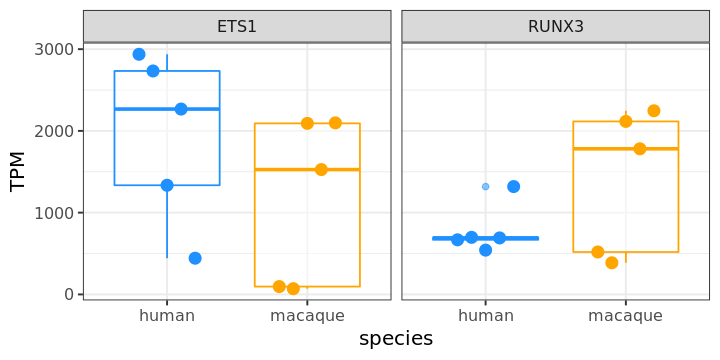

In [43]:
options(repr.plot.width = 6, repr.plot.height = 3)

p <- ggplot(norm_cts, aes(x = species, y = TPM, color = species)) +
    geom_boxplot(alpha = 0.5) +
    geom_point(size = 3, position = position_dodge2(width = 0.5)) +
    facet_wrap(~SYMBOL) +
    theme_bw(base_size = 12) +
    theme(legend.position = "none") +
    scale_color_manual(values = c("dodgerblue", "orange"))

p

In [44]:
ggsave(p, filename = "/data/hodges_lab/ATAC-STARR_B-cells/results/results_human-evolution/ets1+runx3_tpm_human_LCLs-vs-rhesus_LCLs.pdf", 
       device = cairo_pdf, width = 6, height = 3)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.5     ✔ purrr   0.3.4
✔ tibble  3.1.6     ✔ dplyr   1.0.7
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter()  masks stats::filter()
✖ purrr::flatten() masks jsonlite::flatten()
✖ dplyr::lag()     masks stats::lag()



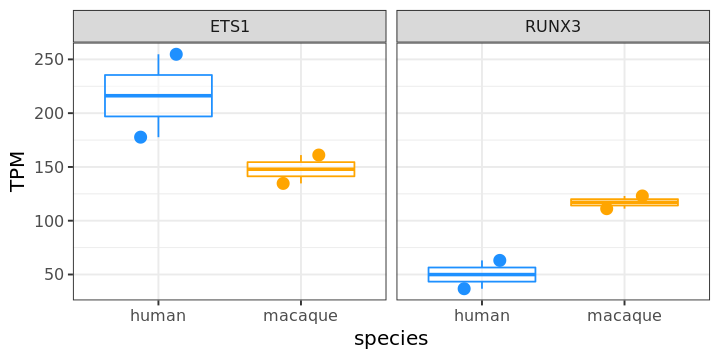

In [1]:
#plot of garcia perez tpm values:
library(tidyverse)

df <- data.frame(SYMBOL = c("ETS1", "ETS1", "ETS1", "ETS1", 
                            "RUNX3", "RUNX3", "RUNX3", "RUNX3"), 
                 replicate = c("Rep1", "Rep2", "Rep1", "Rep2",
                               "Rep1", "Rep2", "Rep1", "Rep2"),
                 species = c("human", "human", "macaque", "macaque", 
                             "human", "human", "macaque", "macaque"), 
                 TPM = c(177.685532, 254.741165, 134.692719, 161.057266,
                         36.793076, 63.099152, 111.201317, 123.005554))

options(repr.plot.width = 6, repr.plot.height = 3)

p <- ggplot(df, aes(x = species, y = TPM, color = species)) +
    geom_boxplot(alpha = 0.5) +
    geom_point(size = 3, position = position_dodge2(width = 0.5)) +
    facet_wrap(~SYMBOL) +
    theme_bw(base_size = 12) +
    theme(legend.position = "none") +
    scale_color_manual(values = c("dodgerblue", "orange"))

p

## Plot trans regulator TFs

In [1]:
library(tidyverse)

df <- read_tsv("/data/hodges_lab/ATAC-STARR_B-cells/data/RNA-seq/count_matricies/diff_expression_res_gene-symbols_human-LCLs-vs-macaque-LCLs.tsv") %>%
    filter(SYMBOL %in% c("NFKB1", "ZBTB7A", "MEF2C", "ETS1", "IRF4", "IRF7", "IRF8"))

df

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.5     ✔ purrr   0.3.4
✔ tibble  3.1.6     ✔ dplyr   1.0.7
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter()  masks stats::filter()
✖ purrr::flatten() masks jsonlite::flatten()
✖ dplyr::lag()     masks stats::lag()

Rows: 20686 Columns: 8

── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr (2): ENSEMBL, SYMBOL
dbl (6): baseMean, log2FoldChange, lfcSE, stat, pvalue, padj


ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.



ENSEMBL,SYMBOL,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
ENSG00000081189,MEF2C,3295.3936,-0.8116663,0.2967016,-2.7356320,6.226060e-03,1.704973e-02
ENSG00000178951,ZBTB7A,1378.7597,-2.0568758,0.2098771,-9.8003834,1.121591e-22,5.603974e-21
ENSG00000140968,IRF8,3645.5499,0.1243153,0.5276426,0.2356052,8.137391e-01,8.713179e-01
ENSG00000137265,IRF4,12518.8886,-1.7702807,0.1261643,-14.0315504,9.994252e-45,2.446129e-42
ENSG00000109320,NFKB1,2139.0889,-1.4328564,0.1915062,-7.4820373,7.317918e-14,1.407574e-12
ENSG00000185507,IRF7,370.1954,-2.3264058,0.5989623,-3.8840607,1.027262e-04,4.581042e-04
ENSG00000134954,ETS1,1667.7822,-1.4886335,0.7991063,-1.8628729,6.248015e-02,1.205644e-01


In [2]:
df$SYMBOL <- factor(df$SYMBOL, levels = c("NFKB1", "ZBTB7A", "MEF2C", "ETS1", "IRF4", "IRF7", "IRF8"))

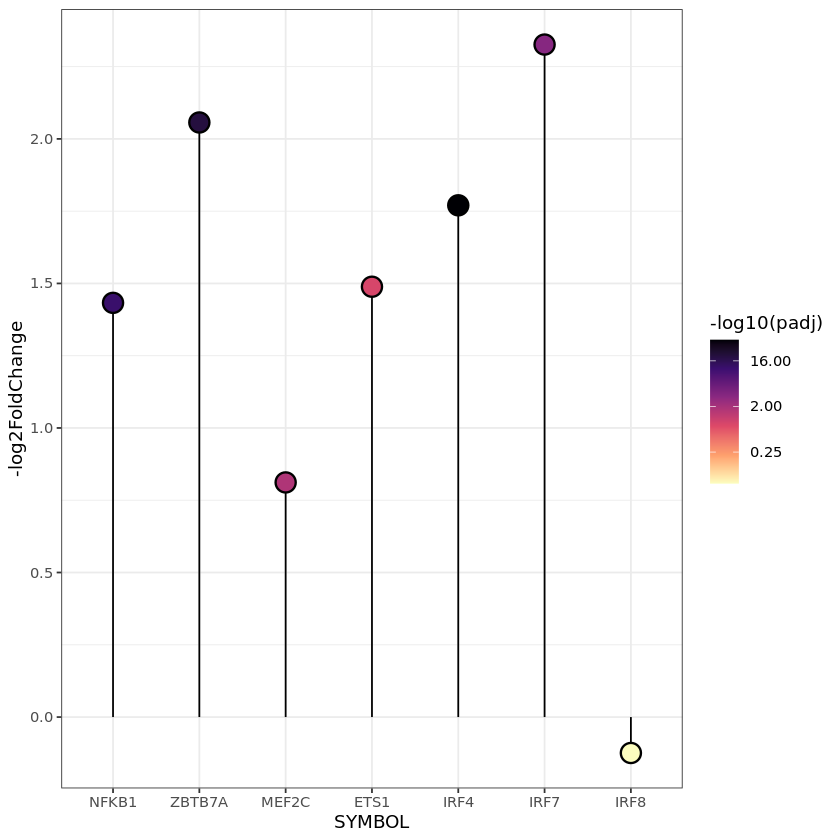

In [3]:
p <-  ggplot(df, aes(x=SYMBOL, y=-log2FoldChange)) +
  geom_segment(aes(x=SYMBOL, xend=SYMBOL, y=0, yend=-log2FoldChange)) +
  geom_point(size=5, color="black", aes(fill=-log10(padj)), shape=21, stroke=1) +
  scale_fill_viridis_c(direction = -1, option = "magma", trans = "log2") +
  theme_bw() +
  theme()

p

### try highlighting in volcano plot

Warning message:
“Removed 284 rows containing missing values (geom_point).”
Warning message:
“Removed 284 rows containing missing values (geom_point).”


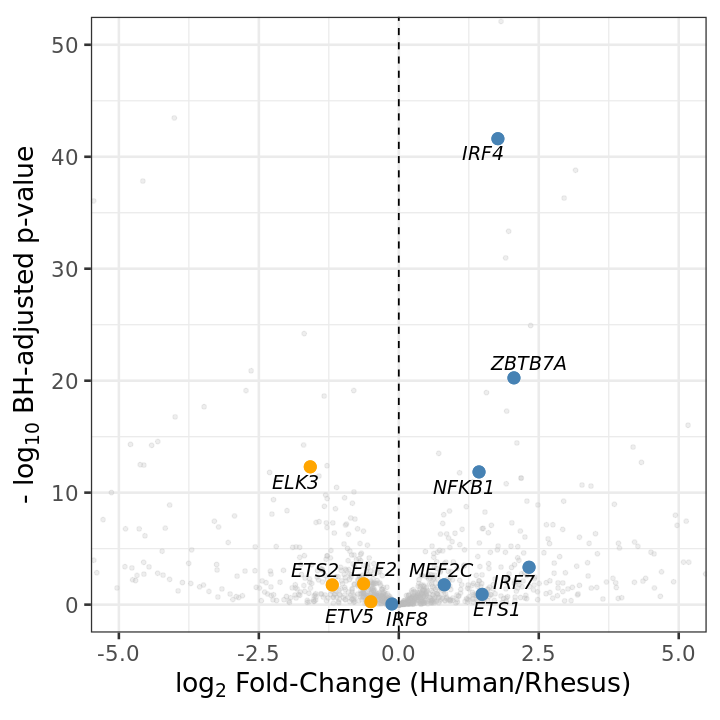

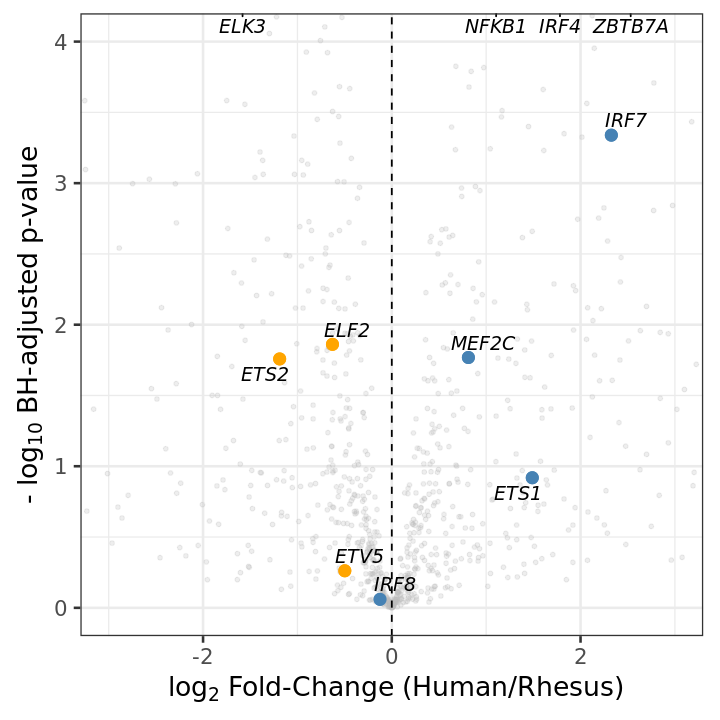

In [24]:
#Plot Volcano plot. First make a new column that classifies each region based on the cutoffs and then order the factored values. 
res_volcano <- mutate(TFs_res, 
                      Classification = case_when(gene_symbol %in% c("NFKB1", "ZBTB7A", "MEF2C", "ETS1", "IRF4", "IRF7", "IRF8") ~ "human",
                                                 gene_symbol %in% c("ETS2", "ELF2", "ELK3", "ETV5") ~ "macaque",
                                                 !gene_symbol %in% c("NFKB1", "ZBTB7A", "MEF2C", "ETS1", "IRF4", "IRF7", "IRF8", 
                                                                     "ETS2", "ELF2", "ELK3", "ETV5") ~ "none"))

res_volcano$Classification <- factor(res_volcano$Classification, levels = c("human", "macaque", "none"))

res_volcano_text <- filter(res_volcano, Classification %in% c("human", "macaque"))

#Plot L2fc and -log10(padj) against each other and color by classificaiton above. 
p <- ggplot(res_volcano, aes(x=-log2FoldChange, y=-log10(padj), colour=Classification)) +
  geom_point(aes(size=Classification, alpha=Classification)) +
  geom_point(data = res_volcano_text, aes(size=Classification, alpha=Classification)) +
  geom_vline(xintercept = c(0), linetype = "dashed", color = "black") +
  ggrepel::geom_text_repel(data = res_volcano_text, aes(x=-log2FoldChange, y=-log10(padj), label=gene_symbol), 
                           fontface = "italic", colour = "black", size = 4, max.overlaps = 30) +
  xlab(bquote(~log[2]~"Fold-Change (Human/Rhesus)")) +
  ylab(bquote("-"~log[10]~"BH-adjusted p-value")) +
  theme_bw(base_size = 16, base_family = "Arial") +
  theme(legend.position="none", legend.title = element_blank(), aspect.ratio=1) +
  scale_colour_manual(values=c("steelblue", "orange", "grey")) + 
  scale_alpha_manual(values = c(1,1,0.25)) +
  scale_size_manual(values = c(3,3,1))

options(repr.plot.width = 6, repr.plot.height = 6)
p + coord_cartesian(xlim = c(-5,5), ylim = c(0,50))
p + coord_cartesian(xlim = c(-3,3), ylim = c(0,4))

In [25]:
ggsave(filename = "/data/hodges_lab/ATAC-STARR_B-cells/results/results_human-evolution/RNA-expression_human-LCLs-vs-rhesus-LCLs_volcano_putative-tfs_highlighted.pdf", 
      plot = p + coord_cartesian(xlim = c(-5,5), ylim = c(0,50)), device = cairo_pdf, height = 6, width = 6)

ggsave(filename = "/data/hodges_lab/ATAC-STARR_B-cells/results/results_human-evolution/RNA-expression_human-LCLs-vs-rhesus-LCLs_volcano_putative-tfs_highlighted_zoom.pdf", 
      plot = p + coord_cartesian(xlim = c(-3,3), ylim = c(0,4)), device = cairo_pdf, height = 6, width = 6)

Warning message:
“Removed 284 rows containing missing values (geom_point).”
Warning message:
“Removed 284 rows containing missing values (geom_point).”
